# Warm-Starting Trajectory Optimization 

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
from IPython.display import HTML
import seaborn as sns

### ... using hard optimization problem 

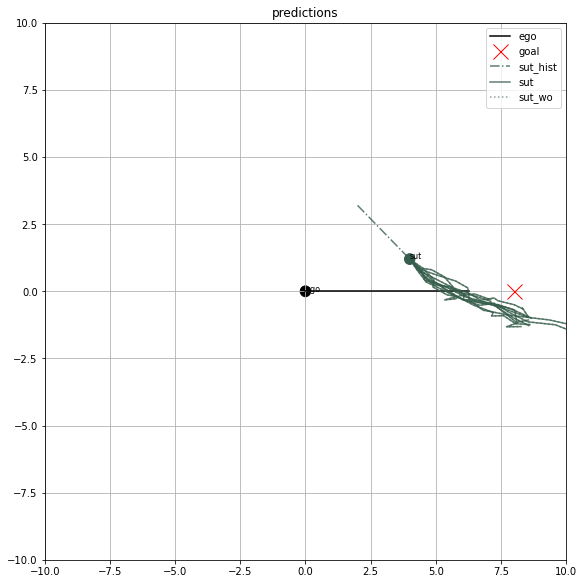

In [13]:
import mantrap
import mantrap_evaluation


env, goal, _ = mantrap_evaluation.scenarios.custom_passing(mantrap.environment.Trajectron)
solver = mantrap.solver.IPOPTSolver(env=env, goal=goal, is_logging=True, t_planning=10)

z_warm_start = solver.warm_start(method=mantrap.constants.WARM_START_HARD)
solver.visualize_step(tag=mantrap.constants.TAG_WARM_START, legend=True)
plt.show()

### ... using soft optimization problem 

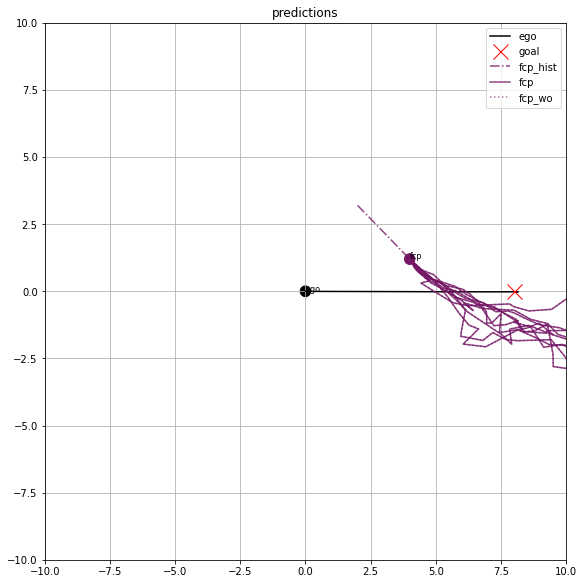

In [16]:
import mantrap
import mantrap_evaluation

env, goal, _ = mantrap_evaluation.scenarios.custom_passing(mantrap.environment.Trajectron)
solver = mantrap.solver.IPOPTSolver(env=env, goal=goal, is_logging=True, t_planning=15)

z_warm_start = solver.warm_start(method=mantrap.constants.WARM_START_SOFT)
solver.visualize_step(tag=mantrap.constants.TAG_WARM_START)
plt.show()

### ... using latent space representation

In [2]:
import mantrap
import numpy as np
import torch


num_latent = 25


def compute_latent(dist: float) -> mantrap.environment.Trajectron:
    env = mantrap.environment.Trajectron(mantrap.agents.DoubleIntegratorDTAgent, 
                                         ego_position=torch.zeros(2))
    env.add_ado(torch.tensor([5, -6]).float() + torch.rand(2) * dist)
    env.compute_distributions_wo_ego(t_horizon=5)
    
    latent_values = np.zeros(num_latent)
    for key, model in env.trajectron.node_models_dict.items():
         latent_values += model.latent.p_dist.probs.flatten().detach().numpy()
    return latent_values

z_undisturbed = compute_latent(dist=0.0)

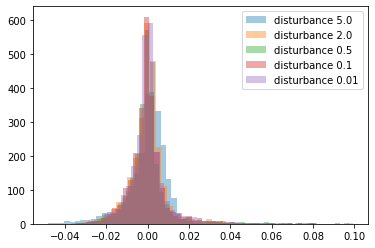

In [3]:
num_samples = 100
disturbances = [5.0, 2.0, 0.5, 0.1, 0.01]

# For each disturbance norm sample several latent space values.
latent_values = np.zeros((len(disturbances), num_samples, num_latent))
for j, dist in enumerate(disturbances):
    for i in range(num_samples):
        latent_values[j, i, :] = compute_latent(dist=dist) 
        
# Plot histogram per disturbance.
diff_undisturbed = latent_values - z_undisturbed
for j, dist in enumerate(disturbances):
    sns.distplot(diff_undisturbed[j, :, :].flatten(), label=f"disturbance {dist}", kde=False)
plt.legend()
plt.show()

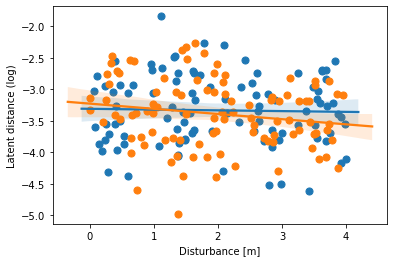

In [5]:
num_samples = 100

dis_dis_values = np.zeros((num_samples, 2))
for i in range(num_samples):
    disturbance = np.random.uniform(0, 4)
    dis_dis_values[i, 0] = disturbance
    dis_dis_values[i, 1] = np.linalg.norm(compute_latent(dist=disturbance) - z_undisturbed)
        
# Plot histogram per disturbance.
sns.regplot(dis_dis_values[:, 0], np.log(dis_dis_values[:, 1]), x_estimator=np.mean)
plt.xlabel("Disturbance [m]")
plt.ylabel("Latent distance (log)")
plt.show()